In [1]:
import matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint

Z_DIM = 2
MAX_VAL = 4.0 # The image spans from -4 to +4 units in the x and y directions.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
class ODEfunc(nn.Module):
	"""
	Calculates time derivatives.
	torchdiffeq requires this to be a torch.nn.Module.
	"""

	def __init__(self, hidden_dims=(64,64,64)):
		super(ODEfunc, self).__init__()
		# Define network layers.
		dim_list = [Z_DIM] + list(hidden_dims) + [Z_DIM]
		layers = []
		for i in range(len(dim_list)-1):
			layers.append(nn.Linear(dim_list[i]+1, dim_list[i+1]))
		self.layers = nn.ModuleList(layers)


	def get_z_dot(self, t, z):
		"""z_dot is parameterized by a NN: z_dot = NN(t, z(t))"""
		z_dot = z
		for l, layer in enumerate(self.layers):
			# Concatenate t at each layer.
			tz_cat = torch.cat((t.expand(z.shape[0],1), z_dot), dim=1)
			z_dot = layer(tz_cat)
			if l < len(self.layers) - 1:
				z_dot = F.softplus(z_dot)
		return z_dot


	def forward(self, t, states):
		"""
		Calculate the time derivative of z and divergence.
		Parameters
		----------
		t : torch.Tensor
			time
		state : tuple
			Contains two torch.Tensors: z and delta_logpz
		Returns
		-------
		z_dot : torch.Tensor
			Time derivative of z.
		negative_divergence : torch.Tensor
			Time derivative of the log determinant of the Jacobian.
		"""
		z = states[0]
		batchsize = z.shape[0]

		with torch.set_grad_enabled(True):
			z.requires_grad_(True)
			t.requires_grad_(True)

			# Calculate the time derivative of z.
			# This is f(z(t), t; \theta) in Eq. 4.
			z_dot = self.get_z_dot(t, z)

			# Calculate the time derivative of the log determinant of the
			# Jacobian.
			# This is -Tr(\partial z_dot / \partial z(t)) in Eq.s 2-4.
			#
			# Note that this is the brute force, O(D^2), method. This is fine
			# for D=2, but the authors suggest using a Monte-carlo estimate
			# of the trace (Hutchinson's trace estimator, eq. 7) for a linear
			# time estimate in larger dimensions.
			divergence = 0.0
			for i in range(z.shape[1]):
				divergence += \
						torch.autograd.grad( \
							z_dot[:, i].sum(), z, create_graph=True \
						)[0][:, i]

		return z_dot, -divergence.view(batchsize, 1)

In [27]:
class FfjordModel(torch.nn.Module):
	"""Continuous noramlizing flow model."""

	def __init__(self):
		super(FfjordModel, self).__init__()
		self.time_deriv_func = ODEfunc()

	def save_state(self, fn='state.tar'):
		"""Save model state."""
		torch.save(self.state_dict(), fn)

	def load_state(self, fn='state.tar'):
		"""Load model state."""
		self.load_state_dict(torch.load(fn))


	def forward(self, z, delta_logpz=None, integration_times=None, \
		reverse=False):
		"""
		Implementation of Eq. 4.
		We want to integrate both f and the trace term. During training, we
		integrate from t_1 (data distribution) to t_0 (base distibution).
		Parameters
		----------
		z : torch.Tensor
			Samples.
		delta_logpz : torch.Tensor
			Log determininant of the Jacobian.
		integration_times : torch.Tensor
			Which times to evaluate at.
		reverse : bool, optional
			Whether to reverse the integration times.
		Returns
		-------
		z : torch.Tensor
			Updated samples.
		delta_logpz : torch.Tensor
			Updated log determinant term.
		"""
		if delta_logpz is None:
			delta_logpz = torch.zeros(z.shape[0], 1).to(device)
		if integration_times is None:
			integration_times = torch.tensor([0.0, 1.0]).to(z)
		if reverse:
			integration_times = _flip(integration_times, 0)

		# Integrate. This is the call to torchdiffeq.
		state = odeint(
			self.time_deriv_func, # Calculates time derivatives.
			(z, delta_logpz), # Values to update.
			integration_times, # When to evaluate.
			method='dopri5', # Runge-Kutta
			atol=[1e-5, 1e-5], # Error tolerance
			rtol=[1e-5, 1e-5], # Error tolerance
		)

		if len(integration_times) == 2:
			state = tuple(s[1] for s in state)
		z, delta_logpz = state
		return z, delta_logpz

In [28]:
def _flip(x, dim):
	indices = [slice(None)] * x.dim()
	indices[dim] = torch.arange(x.size(dim) - 1, -1, -1, dtype=torch.long, \
			device=x.device)
	return x[tuple(indices)]


def standard_normal_logprob(z):
	"""2d standard normal, sum over the second dimension."""
	return (-np.log(2 * np.pi) - 0.5 * z.pow(2)).sum(1, keepdim=True)


In [29]:
# Define the model.
model = FfjordModel()
model.to(device)

FfjordModel(
  (time_deriv_func): ODEfunc(
    (layers): ModuleList(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Linear(in_features=65, out_features=64, bias=True)
      (2): Linear(in_features=65, out_features=64, bias=True)
      (3): Linear(in_features=65, out_features=2, bias=True)
    )
  )
)

In [30]:
# Dataset
import re
import math
import numpy as np
import torch
import scipy.sparse


from sklearn.preprocessing import StandardScaler


class SCData(object):
    """ Base Class for single cell like trajectory data """

    def __init__(self):
        super().__init__()
        self.val_labels = []
        import sklearn.datasets

        self.name = 'scurve'
        # From sklearn auto_examples/cluster/plot_cluster_comparison
        seed = 42
        np.random.seed(seed)
        
        self.data, _ = sklearn.datasets.make_s_curve(
            n_samples=10000, noise=0.05, random_state=seed
        )
        self.data = np.vstack([self.data[:, 0], self.data[:, 2]]).T
        self.data *= 1.5

    def has_validation_samples(self):
        return False

    def get_times(self):
        return np.repeat([0], self.data.shape[0])

    def get_unique_times(self):
        return [0]

    def has_velocity(self):
        return False

    def known_base_density(self):
        return True

    def get_data(self):
        return self.data

    def get_shape(self):
        return [self.data.shape[1]]

    def get_ncells(self):
        return self.data.shape[0]

    def base_density(self):
        def standard_normal_logprob(z):
            logZ = -0.5 * math.log(2 * math.pi)
            return torch.sum(logZ - z.pow(2) / 2, 1, keepdim=True)

        return standard_normal_logprob

    def base_sample(self):
        return torch.randn

    def sample_index(self, n, label_subset):
        arr = np.arange(self.get_ncells())[self.get_times() == label_subset]
        return np.random.choice(arr, size=n)


    def plot_density(self):
        import matplotlib.pyplot as plt

        npts = 100
        side = np.linspace(-4, 4, npts)
        xx, yy = np.meshgrid(side, side)
        xx = torch.from_numpy(xx).type(torch.float32)
        yy = torch.from_numpy(yy).type(torch.float32)
        z_grid = torch.cat([xx.reshape(-1, 1), yy.reshape(-1, 1)], 1)
        logp_grid = data.base_density()(z_grid)
        plt.pcolormesh(xx, yy, np.exp(logp_grid.numpy()).reshape(npts, npts))
        plt.show()

    def plot_data(self):
        import scprep
        import matplotlib.pyplot as plt

        nbase = 5000
        all_data = np.concatenate(
            [self.get_data(), self.base_sample()(nbase, self.get_shape()[0]).numpy()],
            axis=0,
        )
        lbs = np.concatenate([self.get_times(), np.repeat(["Base"], nbase)])
        if all_data.shape[1] == 2:
            scprep.plot.scatter2d(all_data, c=lbs)
        else:
            fig, axes = plt.subplots(2, all_data.shape[1] // 2)
            axes = axes.flatten()
            for i in range(all_data.shape[1] - 1):
                scprep.plot.scatter2d(
                    all_data[:, i : i + 2],
                    c=lbs,
                    ax=axes[i],
                    xlabel="PC %d" % (i + 1),
                    ylabel="PC %d" % (i + 2),
                )
        plt.show()

    def plot_velocity(self):
        import matplotlib.pyplot as plt

        idx = np.random.randint(self.get_ncells(), size=200)
        data = self.get_data()[idx]
        velocity = self.velocity[idx]
        plt.quiver(data[:, 0], data[:, 1], velocity[:, 0], velocity[:, 1])
        plt.show()

    def plot_paths(self):
        paths = self.get_paths()
        paths = paths[:1000]
        import matplotlib.pyplot as plt

        for path in paths:
            plt.plot(path[:, 0], path[:, 1])
        plt.show()

    def factory(name, md):
        if name == "SCURVE":
            return SklearnData("scurve")

In [31]:
scurve = SCData()

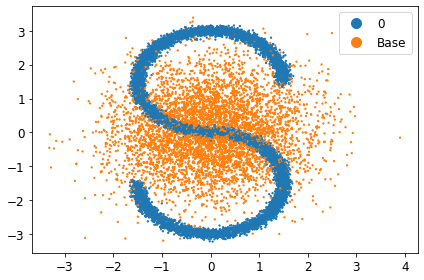

In [59]:
scurve.plot_data()

In [33]:
time_scale = 0.5
timepoints = scurve.get_unique_times()
int_tps = (np.arange(max(timepoints) + 1) + 1.0) * time_scale

In [34]:
print(timepoints)
print(int_tps)

[0]
[0.5]


In [35]:
batch_size = 1000

In [36]:
def compute_loss(model):
    # Backward pass accumulating losses, previous state and deltas
    deltas = []
    zs = []
    z = None
    interp_loss = 0.0
    for i, (itp, tp) in enumerate(zip(int_tps[::-1], timepoints[::-1])):
        # tp counts down from last
        integration_times = torch.tensor([itp - time_scale, itp])
        integration_times = integration_times.type(torch.float32).to(device)
        # integration_times.requires_grad = True

        # load data and add noise
        idx = scurve.sample_index(batch_size, tp)
        x = scurve.get_data()[idx]
#         if args.training_noise > 0.0:
#             x += np.random.randn(*x.shape) * args.training_noise
        x = torch.from_numpy(x).type(torch.float32).to(device)

        if i > 0:
            x = torch.cat((z, x))
            zs.append(z)
        zero = torch.zeros(x.shape[0], 1).to(x)

        # transform to previous timepoint
        z, delta_logp = model(x, zero, integration_times=integration_times)
        deltas.append(delta_logp)

        # Straightline regularization
        # Integrate to random point at time t and assert close to (1 - t) * end + t * start
#         if args.interp_reg:
#             t = np.random.rand()
#             int_t = torch.tensor([itp - t * args.time_scale, itp])
#             int_t = int_t.type(torch.float32).to(device)
#             int_x = model(x, integration_times=int_t)
#             int_x = int_x.detach()
#             actual_int_x = x * (1 - t) + z * t
#             interp_loss += F.mse_loss(int_x, actual_int_x)
#     if args.interp_reg:
#         print("interp_loss", interp_loss)

    logpz = scurve.base_density()(z)

    # build growth rates
#     if args.use_growth:
#         growthrates = [torch.ones_like(logpz)]
#         for z_state, tp in zip(zs[::-1], args.timepoints[:-1]):
#             # Full state includes time parameter to growth_model
#             time_state = tp * torch.ones(z_state.shape[0], 1).to(z_state)
#             full_state = torch.cat([z_state, time_state], 1)
#             growthrates.append(growth_model(full_state))

    # Accumulate losses
    losses = []
    logps = [logpz]
    for i, delta_logp in enumerate(deltas[::-1]):
        logpx = logps[-1] - delta_logp
#         if args.use_growth:
#             logpx += torch.log(torch.clamp(growthrates[i], 1e-4, 1e4))
        logps.append(logpx[: -batch_size])
        losses.append(-torch.mean(logpx[-batch_size :]))
    losses = torch.stack(losses)
    weights = torch.ones_like(losses).to(logpx)
#     if args.leaveout_timepoint >= 0:
#         weights[args.leaveout_timepoint] = 0
    losses = torch.mean(losses * weights)
    
    return losses

In [37]:
# Train.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.train()
for batch in range(2500):
    # Zero gradients.
    optimizer.zero_grad()

    # Sample from the image distribution.
    loss = compute_loss(model)
    print(loss)

    # Take an optimization step.
    loss.backward()
    optimizer.step()

tensor(4.6402, grad_fn=<MeanBackward0>)
tensor(4.5269, grad_fn=<MeanBackward0>)
tensor(4.5700, grad_fn=<MeanBackward0>)
tensor(4.5857, grad_fn=<MeanBackward0>)
tensor(4.5460, grad_fn=<MeanBackward0>)
tensor(4.4888, grad_fn=<MeanBackward0>)
tensor(4.4232, grad_fn=<MeanBackward0>)
tensor(4.5252, grad_fn=<MeanBackward0>)
tensor(4.4398, grad_fn=<MeanBackward0>)
tensor(4.4534, grad_fn=<MeanBackward0>)
tensor(4.4525, grad_fn=<MeanBackward0>)
tensor(4.4263, grad_fn=<MeanBackward0>)
tensor(4.3315, grad_fn=<MeanBackward0>)
tensor(4.3302, grad_fn=<MeanBackward0>)
tensor(4.3551, grad_fn=<MeanBackward0>)
tensor(4.3040, grad_fn=<MeanBackward0>)
tensor(4.2851, grad_fn=<MeanBackward0>)
tensor(4.2895, grad_fn=<MeanBackward0>)
tensor(4.2039, grad_fn=<MeanBackward0>)
tensor(4.1593, grad_fn=<MeanBackward0>)
tensor(4.1223, grad_fn=<MeanBackward0>)
tensor(4.0681, grad_fn=<MeanBackward0>)
tensor(4.0826, grad_fn=<MeanBackward0>)
tensor(4.0128, grad_fn=<MeanBackward0>)
tensor(4.0035, grad_fn=<MeanBackward0>)


tensor(3.5369, grad_fn=<MeanBackward0>)
tensor(3.5443, grad_fn=<MeanBackward0>)
tensor(3.5481, grad_fn=<MeanBackward0>)
tensor(3.5521, grad_fn=<MeanBackward0>)
tensor(3.5356, grad_fn=<MeanBackward0>)
tensor(3.5402, grad_fn=<MeanBackward0>)
tensor(3.5424, grad_fn=<MeanBackward0>)
tensor(3.5000, grad_fn=<MeanBackward0>)
tensor(3.5361, grad_fn=<MeanBackward0>)
tensor(3.5334, grad_fn=<MeanBackward0>)
tensor(3.5214, grad_fn=<MeanBackward0>)
tensor(3.5283, grad_fn=<MeanBackward0>)
tensor(3.5151, grad_fn=<MeanBackward0>)
tensor(3.5158, grad_fn=<MeanBackward0>)
tensor(3.5111, grad_fn=<MeanBackward0>)
tensor(3.5315, grad_fn=<MeanBackward0>)
tensor(3.5290, grad_fn=<MeanBackward0>)
tensor(3.5257, grad_fn=<MeanBackward0>)
tensor(3.5003, grad_fn=<MeanBackward0>)
tensor(3.5050, grad_fn=<MeanBackward0>)
tensor(3.5224, grad_fn=<MeanBackward0>)
tensor(3.5187, grad_fn=<MeanBackward0>)
tensor(3.5047, grad_fn=<MeanBackward0>)
tensor(3.5088, grad_fn=<MeanBackward0>)
tensor(3.5071, grad_fn=<MeanBackward0>)


tensor(3.1565, grad_fn=<MeanBackward0>)
tensor(3.1317, grad_fn=<MeanBackward0>)
tensor(3.1570, grad_fn=<MeanBackward0>)
tensor(3.1174, grad_fn=<MeanBackward0>)
tensor(3.1361, grad_fn=<MeanBackward0>)
tensor(3.1279, grad_fn=<MeanBackward0>)
tensor(3.1221, grad_fn=<MeanBackward0>)
tensor(3.0680, grad_fn=<MeanBackward0>)
tensor(3.1067, grad_fn=<MeanBackward0>)
tensor(3.1557, grad_fn=<MeanBackward0>)
tensor(3.0966, grad_fn=<MeanBackward0>)
tensor(3.1024, grad_fn=<MeanBackward0>)
tensor(3.0867, grad_fn=<MeanBackward0>)
tensor(3.0826, grad_fn=<MeanBackward0>)
tensor(3.0849, grad_fn=<MeanBackward0>)
tensor(3.0697, grad_fn=<MeanBackward0>)
tensor(3.1250, grad_fn=<MeanBackward0>)
tensor(3.0908, grad_fn=<MeanBackward0>)
tensor(3.0998, grad_fn=<MeanBackward0>)
tensor(3.0828, grad_fn=<MeanBackward0>)
tensor(3.0784, grad_fn=<MeanBackward0>)
tensor(3.0901, grad_fn=<MeanBackward0>)
tensor(3.0620, grad_fn=<MeanBackward0>)
tensor(3.0212, grad_fn=<MeanBackward0>)
tensor(3.0288, grad_fn=<MeanBackward0>)


tensor(2.1528, grad_fn=<MeanBackward0>)
tensor(2.2892, grad_fn=<MeanBackward0>)
tensor(2.1597, grad_fn=<MeanBackward0>)
tensor(2.2213, grad_fn=<MeanBackward0>)
tensor(2.2084, grad_fn=<MeanBackward0>)
tensor(2.1291, grad_fn=<MeanBackward0>)
tensor(2.1778, grad_fn=<MeanBackward0>)
tensor(2.2535, grad_fn=<MeanBackward0>)
tensor(2.1654, grad_fn=<MeanBackward0>)
tensor(2.1577, grad_fn=<MeanBackward0>)
tensor(2.1234, grad_fn=<MeanBackward0>)
tensor(2.1150, grad_fn=<MeanBackward0>)
tensor(2.1725, grad_fn=<MeanBackward0>)
tensor(2.1657, grad_fn=<MeanBackward0>)
tensor(2.1734, grad_fn=<MeanBackward0>)
tensor(2.1522, grad_fn=<MeanBackward0>)
tensor(2.0618, grad_fn=<MeanBackward0>)
tensor(2.1499, grad_fn=<MeanBackward0>)
tensor(2.1498, grad_fn=<MeanBackward0>)
tensor(2.1528, grad_fn=<MeanBackward0>)
tensor(2.2177, grad_fn=<MeanBackward0>)
tensor(2.1574, grad_fn=<MeanBackward0>)
tensor(2.1230, grad_fn=<MeanBackward0>)
tensor(2.1864, grad_fn=<MeanBackward0>)
tensor(2.1063, grad_fn=<MeanBackward0>)


tensor(1.7841, grad_fn=<MeanBackward0>)
tensor(1.7131, grad_fn=<MeanBackward0>)
tensor(1.6761, grad_fn=<MeanBackward0>)
tensor(1.7150, grad_fn=<MeanBackward0>)
tensor(1.7392, grad_fn=<MeanBackward0>)
tensor(1.6997, grad_fn=<MeanBackward0>)
tensor(1.7127, grad_fn=<MeanBackward0>)
tensor(1.7045, grad_fn=<MeanBackward0>)
tensor(1.6857, grad_fn=<MeanBackward0>)
tensor(1.7409, grad_fn=<MeanBackward0>)
tensor(1.6738, grad_fn=<MeanBackward0>)
tensor(1.7725, grad_fn=<MeanBackward0>)
tensor(1.7302, grad_fn=<MeanBackward0>)
tensor(1.6883, grad_fn=<MeanBackward0>)
tensor(1.6911, grad_fn=<MeanBackward0>)
tensor(1.7020, grad_fn=<MeanBackward0>)
tensor(1.6995, grad_fn=<MeanBackward0>)
tensor(1.7365, grad_fn=<MeanBackward0>)
tensor(1.7004, grad_fn=<MeanBackward0>)
tensor(1.7181, grad_fn=<MeanBackward0>)
tensor(1.7728, grad_fn=<MeanBackward0>)
tensor(1.6981, grad_fn=<MeanBackward0>)
tensor(1.7997, grad_fn=<MeanBackward0>)
tensor(1.7359, grad_fn=<MeanBackward0>)
tensor(1.7284, grad_fn=<MeanBackward0>)


tensor(1.5783, grad_fn=<MeanBackward0>)
tensor(1.5669, grad_fn=<MeanBackward0>)
tensor(1.6527, grad_fn=<MeanBackward0>)
tensor(1.5839, grad_fn=<MeanBackward0>)
tensor(1.6166, grad_fn=<MeanBackward0>)
tensor(1.5724, grad_fn=<MeanBackward0>)
tensor(1.5783, grad_fn=<MeanBackward0>)
tensor(1.6077, grad_fn=<MeanBackward0>)
tensor(1.6003, grad_fn=<MeanBackward0>)
tensor(1.5697, grad_fn=<MeanBackward0>)
tensor(1.6164, grad_fn=<MeanBackward0>)
tensor(1.6320, grad_fn=<MeanBackward0>)
tensor(1.6111, grad_fn=<MeanBackward0>)
tensor(1.6022, grad_fn=<MeanBackward0>)
tensor(1.6511, grad_fn=<MeanBackward0>)
tensor(1.6411, grad_fn=<MeanBackward0>)
tensor(1.6290, grad_fn=<MeanBackward0>)
tensor(1.6878, grad_fn=<MeanBackward0>)
tensor(1.6283, grad_fn=<MeanBackward0>)
tensor(1.6061, grad_fn=<MeanBackward0>)
tensor(1.6532, grad_fn=<MeanBackward0>)
tensor(1.5581, grad_fn=<MeanBackward0>)
tensor(1.6634, grad_fn=<MeanBackward0>)
tensor(1.6975, grad_fn=<MeanBackward0>)
tensor(1.5527, grad_fn=<MeanBackward0>)


tensor(1.5887, grad_fn=<MeanBackward0>)
tensor(1.6119, grad_fn=<MeanBackward0>)
tensor(1.5998, grad_fn=<MeanBackward0>)
tensor(1.5609, grad_fn=<MeanBackward0>)
tensor(1.5881, grad_fn=<MeanBackward0>)
tensor(1.6044, grad_fn=<MeanBackward0>)
tensor(1.5994, grad_fn=<MeanBackward0>)
tensor(1.5870, grad_fn=<MeanBackward0>)
tensor(1.5560, grad_fn=<MeanBackward0>)
tensor(1.5820, grad_fn=<MeanBackward0>)
tensor(1.5733, grad_fn=<MeanBackward0>)
tensor(1.6446, grad_fn=<MeanBackward0>)
tensor(1.5842, grad_fn=<MeanBackward0>)
tensor(1.5660, grad_fn=<MeanBackward0>)
tensor(1.5642, grad_fn=<MeanBackward0>)
tensor(1.5333, grad_fn=<MeanBackward0>)
tensor(1.5668, grad_fn=<MeanBackward0>)
tensor(1.6001, grad_fn=<MeanBackward0>)
tensor(1.6092, grad_fn=<MeanBackward0>)
tensor(1.5967, grad_fn=<MeanBackward0>)
tensor(1.6073, grad_fn=<MeanBackward0>)
tensor(1.5798, grad_fn=<MeanBackward0>)
tensor(1.6150, grad_fn=<MeanBackward0>)
tensor(1.6281, grad_fn=<MeanBackward0>)
tensor(1.6105, grad_fn=<MeanBackward0>)


tensor(1.5901, grad_fn=<MeanBackward0>)
tensor(1.5511, grad_fn=<MeanBackward0>)
tensor(1.5882, grad_fn=<MeanBackward0>)
tensor(1.5581, grad_fn=<MeanBackward0>)
tensor(1.5388, grad_fn=<MeanBackward0>)
tensor(1.6103, grad_fn=<MeanBackward0>)
tensor(1.5456, grad_fn=<MeanBackward0>)
tensor(1.5961, grad_fn=<MeanBackward0>)
tensor(1.5639, grad_fn=<MeanBackward0>)
tensor(1.5690, grad_fn=<MeanBackward0>)
tensor(1.5754, grad_fn=<MeanBackward0>)
tensor(1.5156, grad_fn=<MeanBackward0>)
tensor(1.5965, grad_fn=<MeanBackward0>)
tensor(1.5885, grad_fn=<MeanBackward0>)
tensor(1.6073, grad_fn=<MeanBackward0>)
tensor(1.5620, grad_fn=<MeanBackward0>)
tensor(1.6099, grad_fn=<MeanBackward0>)
tensor(1.5659, grad_fn=<MeanBackward0>)
tensor(1.6035, grad_fn=<MeanBackward0>)
tensor(1.5544, grad_fn=<MeanBackward0>)
tensor(1.5719, grad_fn=<MeanBackward0>)
tensor(1.5906, grad_fn=<MeanBackward0>)
tensor(1.5296, grad_fn=<MeanBackward0>)
tensor(1.5471, grad_fn=<MeanBackward0>)
tensor(1.5795, grad_fn=<MeanBackward0>)


tensor(1.5671, grad_fn=<MeanBackward0>)
tensor(1.5841, grad_fn=<MeanBackward0>)
tensor(1.5476, grad_fn=<MeanBackward0>)
tensor(1.5496, grad_fn=<MeanBackward0>)
tensor(1.5373, grad_fn=<MeanBackward0>)
tensor(1.5562, grad_fn=<MeanBackward0>)
tensor(1.5690, grad_fn=<MeanBackward0>)
tensor(1.5804, grad_fn=<MeanBackward0>)
tensor(1.5363, grad_fn=<MeanBackward0>)
tensor(1.5198, grad_fn=<MeanBackward0>)
tensor(1.5572, grad_fn=<MeanBackward0>)
tensor(1.5766, grad_fn=<MeanBackward0>)
tensor(1.5561, grad_fn=<MeanBackward0>)
tensor(1.5643, grad_fn=<MeanBackward0>)
tensor(1.5695, grad_fn=<MeanBackward0>)
tensor(1.5313, grad_fn=<MeanBackward0>)
tensor(1.5697, grad_fn=<MeanBackward0>)
tensor(1.5479, grad_fn=<MeanBackward0>)
tensor(1.5463, grad_fn=<MeanBackward0>)
tensor(1.6138, grad_fn=<MeanBackward0>)
tensor(1.5524, grad_fn=<MeanBackward0>)
tensor(1.5179, grad_fn=<MeanBackward0>)
tensor(1.5564, grad_fn=<MeanBackward0>)
tensor(1.5376, grad_fn=<MeanBackward0>)
tensor(1.5187, grad_fn=<MeanBackward0>)


tensor(1.5633, grad_fn=<MeanBackward0>)
tensor(1.5274, grad_fn=<MeanBackward0>)
tensor(1.5647, grad_fn=<MeanBackward0>)
tensor(1.5996, grad_fn=<MeanBackward0>)
tensor(1.5672, grad_fn=<MeanBackward0>)
tensor(1.5594, grad_fn=<MeanBackward0>)
tensor(1.5146, grad_fn=<MeanBackward0>)
tensor(1.5531, grad_fn=<MeanBackward0>)
tensor(1.5855, grad_fn=<MeanBackward0>)
tensor(1.5399, grad_fn=<MeanBackward0>)
tensor(1.5833, grad_fn=<MeanBackward0>)
tensor(1.5376, grad_fn=<MeanBackward0>)
tensor(1.5421, grad_fn=<MeanBackward0>)
tensor(1.5777, grad_fn=<MeanBackward0>)
tensor(1.5395, grad_fn=<MeanBackward0>)
tensor(1.5651, grad_fn=<MeanBackward0>)
tensor(1.5490, grad_fn=<MeanBackward0>)
tensor(1.5329, grad_fn=<MeanBackward0>)
tensor(1.5725, grad_fn=<MeanBackward0>)
tensor(1.5946, grad_fn=<MeanBackward0>)
tensor(1.5254, grad_fn=<MeanBackward0>)
tensor(1.5787, grad_fn=<MeanBackward0>)
tensor(1.5697, grad_fn=<MeanBackward0>)
tensor(1.5639, grad_fn=<MeanBackward0>)
tensor(1.5603, grad_fn=<MeanBackward0>)


tensor(1.5481, grad_fn=<MeanBackward0>)
tensor(1.5025, grad_fn=<MeanBackward0>)
tensor(1.5669, grad_fn=<MeanBackward0>)
tensor(1.5345, grad_fn=<MeanBackward0>)
tensor(1.5682, grad_fn=<MeanBackward0>)
tensor(1.5634, grad_fn=<MeanBackward0>)
tensor(1.5568, grad_fn=<MeanBackward0>)
tensor(1.5689, grad_fn=<MeanBackward0>)
tensor(1.5540, grad_fn=<MeanBackward0>)
tensor(1.5655, grad_fn=<MeanBackward0>)
tensor(1.5753, grad_fn=<MeanBackward0>)
tensor(1.5639, grad_fn=<MeanBackward0>)
tensor(1.5982, grad_fn=<MeanBackward0>)
tensor(1.5232, grad_fn=<MeanBackward0>)
tensor(1.5748, grad_fn=<MeanBackward0>)
tensor(1.5455, grad_fn=<MeanBackward0>)
tensor(1.5718, grad_fn=<MeanBackward0>)
tensor(1.5513, grad_fn=<MeanBackward0>)
tensor(1.6206, grad_fn=<MeanBackward0>)
tensor(1.5043, grad_fn=<MeanBackward0>)
tensor(1.6111, grad_fn=<MeanBackward0>)
tensor(1.5720, grad_fn=<MeanBackward0>)
tensor(1.5567, grad_fn=<MeanBackward0>)
tensor(1.5321, grad_fn=<MeanBackward0>)
tensor(1.5688, grad_fn=<MeanBackward0>)


tensor(1.5521, grad_fn=<MeanBackward0>)
tensor(1.5327, grad_fn=<MeanBackward0>)
tensor(1.5341, grad_fn=<MeanBackward0>)
tensor(1.5275, grad_fn=<MeanBackward0>)
tensor(1.4970, grad_fn=<MeanBackward0>)
tensor(1.5630, grad_fn=<MeanBackward0>)
tensor(1.5394, grad_fn=<MeanBackward0>)
tensor(1.5579, grad_fn=<MeanBackward0>)
tensor(1.5486, grad_fn=<MeanBackward0>)
tensor(1.5453, grad_fn=<MeanBackward0>)
tensor(1.5193, grad_fn=<MeanBackward0>)
tensor(1.5981, grad_fn=<MeanBackward0>)
tensor(1.5374, grad_fn=<MeanBackward0>)
tensor(1.5119, grad_fn=<MeanBackward0>)
tensor(1.5418, grad_fn=<MeanBackward0>)
tensor(1.5362, grad_fn=<MeanBackward0>)
tensor(1.5459, grad_fn=<MeanBackward0>)
tensor(1.5554, grad_fn=<MeanBackward0>)
tensor(1.5502, grad_fn=<MeanBackward0>)
tensor(1.5842, grad_fn=<MeanBackward0>)
tensor(1.5905, grad_fn=<MeanBackward0>)
tensor(1.5331, grad_fn=<MeanBackward0>)
tensor(1.4999, grad_fn=<MeanBackward0>)
tensor(1.5629, grad_fn=<MeanBackward0>)
tensor(1.5668, grad_fn=<MeanBackward0>)


tensor(1.5100, grad_fn=<MeanBackward0>)
tensor(1.5253, grad_fn=<MeanBackward0>)
tensor(1.4894, grad_fn=<MeanBackward0>)
tensor(1.5712, grad_fn=<MeanBackward0>)
tensor(1.5600, grad_fn=<MeanBackward0>)
tensor(1.5324, grad_fn=<MeanBackward0>)
tensor(1.5347, grad_fn=<MeanBackward0>)
tensor(1.5950, grad_fn=<MeanBackward0>)
tensor(1.5131, grad_fn=<MeanBackward0>)
tensor(1.5934, grad_fn=<MeanBackward0>)
tensor(1.5196, grad_fn=<MeanBackward0>)
tensor(1.5514, grad_fn=<MeanBackward0>)
tensor(1.5180, grad_fn=<MeanBackward0>)
tensor(1.5602, grad_fn=<MeanBackward0>)
tensor(1.5484, grad_fn=<MeanBackward0>)
tensor(1.5403, grad_fn=<MeanBackward0>)
tensor(1.5472, grad_fn=<MeanBackward0>)
tensor(1.5317, grad_fn=<MeanBackward0>)
tensor(1.5831, grad_fn=<MeanBackward0>)
tensor(1.5414, grad_fn=<MeanBackward0>)
tensor(1.5684, grad_fn=<MeanBackward0>)
tensor(1.5616, grad_fn=<MeanBackward0>)
tensor(1.5530, grad_fn=<MeanBackward0>)
tensor(1.5858, grad_fn=<MeanBackward0>)
tensor(1.5363, grad_fn=<MeanBackward0>)


In [39]:
# Visualize Output

def get_transforms(model, integration_times):

    def sample_fn(z, logpz=None):
        int_list = [
            torch.tensor([it - time_scale, it]).type(torch.float32).to(device)
            for it in integration_times
        ]
        if logpz is not None:
            # TODO this works right?
            for it in int_list:
                z, logpz = model(z, logpz, integration_times=it, reverse=True)
            return z, logpz
        else:
            for it in int_list:
                z = model(z, integration_times=it, reverse=True)
            return z

    def density_fn(x, logpx=None):
        int_list = [
            torch.tensor([it - time_scale, it]).type(torch.float32).to(device)
            for it in integration_times[::-1]
        ]
        if logpx is not None:
            for it in int_list:
                x, logpx = model(x, logpx, integration_times=it, reverse=False)
            return x, logpx
        else:
            for it in int_list:
                x = model(x, integration_times=it, reverse=False)
            return x

    return sample_fn, density_fn

In [145]:
# import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import torch

LOW = -4
HIGH = 4


def plt_potential_func(potential, ax, npts=100, title="$p(x)$"):
    """
    Args:
        potential: computes U(z_k) given z_k
    """
    xside = np.linspace(LOW, HIGH, npts)
    yside = np.linspace(LOW, HIGH, npts)
    xx, yy = np.meshgrid(xside, yside)
    z = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    z = torch.Tensor(z)
    u = potential(z).cpu().numpy()
    p = np.exp(-u).reshape(npts, npts)

    plt.pcolormesh(xx, yy, p)
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_flow(prior_logdensity, transform, ax, npts=100, title="$q(x)$ Generated", device="cpu"):
    """
    Args:
        transform: computes z_k and log(q_k) given z_0
    """
    side = np.linspace(LOW, HIGH, npts)
    xx, yy = np.meshgrid(side, side)
    z = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    z = torch.tensor(z, requires_grad=True).type(torch.float32).to(device)
    logqz = prior_logdensity(z)
    z, logqz = transform(z, logqz)
    logqz = torch.sum(logqz, dim=1)[:, None]

    xx = z[:, 0].cpu().detach().numpy().reshape(npts, npts)
    yy = z[:, 1].cpu().detach().numpy().reshape(npts, npts)
    qz = np.exp(logqz.cpu().detach().numpy()).reshape(npts, npts)

    plt.pcolormesh(xx, yy, qz)
    ax.set_xlim(LOW, HIGH)
    ax.set_ylim(LOW, HIGH)
    cmap = matplotlib.cm.get_cmap(None)
    ax.set_facecolor(cmap(0.))
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_flow_density(prior_logdensity, inverse_transform, ax, npts=100, memory=100, title="$q(x)$ True", device="cpu"):
    side = np.linspace(LOW, HIGH, npts)
    xx, yy = np.meshgrid(side, side)
    x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

    x = torch.from_numpy(x).type(torch.float32).to(device)
    zeros = torch.zeros(x.shape[0], 1).to(x)

    z, delta_logp = [], []
    inds = torch.arange(0, x.shape[0]).to(torch.int64)
    for ii in torch.split(inds, int(memory**2)):
        z_, delta_logp_ = inverse_transform(x[ii], zeros[ii])
        z.append(z_)
        delta_logp.append(delta_logp_)
    z = torch.cat(z, 0)
    delta_logp = torch.cat(delta_logp, 0)

    logpz = prior_logdensity(z)
    logpx = logpz - delta_logp

    px = np.exp(logpx.detach().numpy()).reshape(npts, npts)

    ax.imshow(px)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_flow_samples(prior_sample, transform, ax, npts=100, memory=100, title="$x ~ q(x)$ Generated", device="cpu"):
#     z = prior_sample(npts * npts, 2).type(torch.float32).to(device)
#     zk = []
#     inds = torch.arange(0, z.shape[0]).to(torch.int64)
#     for ii in torch.split(inds, int(memory**2)):
#         zk.append(transform(z[ii]))
#     zk = torch.cat(zk[0], 0).cpu().numpy()

    z = transform(prior_sample(npts * npts, 2).type(torch.float32).to(device))[0]
    zk = z.detach().numpy()
    ax.hist2d(zk[:, 0], zk[:, 1], range=[[LOW, HIGH], [LOW, HIGH]], bins=npts)
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)


def plt_samples(samples, ax, npts=100, title="$x ~ p(x)$ True"):
    ax.hist2d(samples[:, 0], samples[:, 1], range=[[LOW, HIGH], [LOW, HIGH]], bins=npts)
    ax.invert_yaxis()
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.set_title(title)

def visualize_growth(growth_model, full_data, labels, npts=200, memory=100, device='cpu'):
    with torch.no_grad():
        fig, ax = plt.subplots(1,1)
        side = np.linspace(LOW, HIGH, npts)
        xx, yy = np.meshgrid(side, side)
        x = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])
        x = torch.from_numpy(x).type(torch.float32).to(device)
        output_growth = growth_model(x).cpu().numpy()
        output_growth = np.reshape(output_growth, (npts, npts))
        im = ax.imshow(output_growth, cmap = 'bwr')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        fig.colorbar(im, ax=ax)
        ax.set_title('Growth Rate')
        
        # rescale full data to image coordinates
        full_data = full_data * npts / 8 + npts / 2
        #ax.scatter(full_data[:,0], full_data[:,1], c=labels / 5, cmap='Spectral', s=10,alpha=0.5)


def visualize_transform(
    potential_or_samples, prior_sample, prior_density, transform=None, inverse_transform=None, samples=True, npts=100,
    memory=100, device="cpu"
):
    """Produces visualization for the model density and samples from the model."""
    plt.clf()
    ax = plt.subplot(1, 3, 1, aspect="equal")
    if samples:
        plt_samples(potential_or_samples, ax, npts=npts)
    else:
        plt_potential_func(potential_or_samples, ax, npts=npts)

    ax = plt.subplot(1, 3, 2, aspect="equal")
    if inverse_transform is None:
        plt_flow(prior_density, transform, ax, npts=npts, device=device)
    else:
        plt_flow_density(prior_density, inverse_transform, ax, npts=npts, memory=memory, device=device)

    ax = plt.subplot(1, 3, 3, aspect="equal")
    if transform is not None:
        plt_flow_samples(prior_sample, transform, ax, npts=npts, memory=memory, device=device)

In [152]:
def visualize(device, model, itr):
    model.eval()
    for i, tp in enumerate(timepoints):
        idx = scurve.sample_index(1000, tp)
        p_samples = scurve.get_data()[idx]
        sample_fn, density_fn = get_transforms(
            model, int_tps[: i + 1]
        )
        plt.figure(figsize=(9, 3))
        visualize_transform(
            p_samples,
            scurve.base_sample(),
            scurve.base_density(),
            transform=sample_fn,
            inverse_transform=density_fn, #density_fn
            samples=True,
            npts=100,
            device=device,
        )
#         fig_filename = os.path.join(
#             args.save, "figs", "{:04d}_{:01d}.jpg".format(itr, i)
#         )
#         utils.makedirs(os.path.dirname(fig_filename))
#         plt.savefig(fig_filename)
        plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


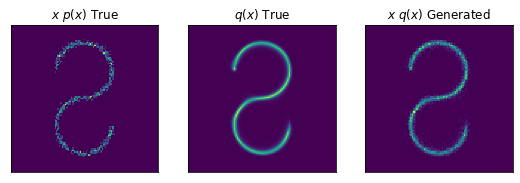

In [153]:
visualize(device, model, 2500)